# Exp2：基于回归分析的大学综合得分预测
---

## 一、案例简介
大学排名是一个非常重要同时也极富挑战性与争议性的问题，一所大学的综合实力涉及科研、师资、学生等方方面面。目前全球有上百家评估机构会评估大学的综合得分进行排序，而这些机构的打分也往往并不一致。在这些评分机构中，世界大学排名中心（Center for World University Rankings，缩写CWUR）以评估教育质量、校友就业、研究成果和引用，而非依赖于调查和大学所提交的数据著称，是非常有影响力的一个。

本任务中我们将根据 CWUR 所提供的世界各地知名大学各方面的排名（师资、科研等），一方面通过数据可视化的方式观察不同大学的特点，另一方面希望构建机器学习模型（线性回归）预测一所大学的综合得分。

## 二、作业说明
使用来自 Kaggle 的[数据](https://www.kaggle.com/mylesoneill/world-university-rankings?select=cwurData.csv)，构建「线性回归」模型，根据大学各项指标的排名预测综合得分。

**基本要求：**
* 按照 8:2 随机划分训练集测试集，用 RMSE 作为评价指标，得到测试集上线性回归模型的 RMSE 值；
* 对线性回归模型的系数进行分析。

**扩展要求：**
* 对数据进行观察与可视化，展示数据特点；
* 尝试其他的回归模型，对比效果；
* 尝试将离散的地区特征融入线性回归模型，并对结果进行对比。

**注意事项：**
* 基本输入特征有 8 个：`quality_of_education`, `alumni_employment`, `quality_of_faculty`, `publications`, `influence`, `citations`, `broad_impact`, `patents`；
* 预测目标为`score`；
* 可以使用 sklearn 等第三方库，不要求自己实现线性回归；
* 需要保留所有数据集生成、模型训练测试的代码；

## 三、数据概览

假设数据文件位于当前文件夹，我们用 pandas 读入标准 csv 格式文件的函数`read_csv()`将数据转换为`DataFrame`的形式。观察前几条数据记录：

In [440]:
import pandas as pd
import numpy as np
# 用于绘制相关性
import matplotlib.pyplot as plt
# 用于划分训练集和测试集
from sklearn.model_selection import train_test_split,KFold
# 用于计算RMSE
from sklearn.metrics import root_mean_squared_error , mean_squared_error , r2_score
# 用于特征值的归一化
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer
# 用来进行线性回归
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
RANDOM_SEED = 2020

data_df = pd.read_csv('./cwurData.csv')  # 读入 csv 文件为 pandas 的 DataFrame
data_df.head(3).T  # 观察前几列并转置方便观察

,0,1,2
world_rank,1,2,3
institution,Harvard University,Massachusetts Institute of Technology,Stanford University
region,USA,USA,USA
national_rank,1,2,3
quality_of_education,7,9,17
alumni_employment,9,17,11
quality_of_faculty,1,3,5
publications,1,12,4
influence,1,4,2
citations,1,4,2


去除其中包含 NaN 的数据，保留 2000 条有效记录。

In [441]:
data_df = data_df.dropna()  # 舍去包含 NaN 的 row
len(data_df)

2000

In [442]:
# 先翻译一下属性
print(data_df.keys())

Index(['world_rank', 'institution', 'region', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents',
       'score', 'year'],
      dtype='object')


## 添加内容： 特征相关性分析和可视化 && 类别特征融入回归模型 
### 类别型特征region 的处理方法：
类别型特征 的处理方法是 转换成数值类型特征，常用的方法是：
1. One—Hot Encoding ，将每个region变成一个remap成一个新的feature ， 优点是类别无序，缺点是引入高纬稀疏矩阵，增加计算量
2. Label Encoding，标签编码，类型特征比如region 变成USA=1 , United Kingdom=2 等。这种编码会人为引入顺序性和大小关系，比如 UK>USA,不适合用于线性回归
3. Target Encoding：用每个类别在训练数据中对应目标值的统计值（通常是均值）来替代类别变量。
>Target Encoding 的一个最大风险：它直接使用了目标变量，如果不处理，会导致模型在训练集上“看到答案”，从而过拟合。

In [443]:

def target_encoding(origin_data_df):
    # 复制一份数据
    df = origin_data_df.copy()
    df['region_encoded'] = np.nan  # 创建新的编码列

    # 参数设置
    region_col = 'region'
    target_col = 'score'
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # KFold交叉编码
    for train_idx, val_idx in kf.split(df):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        # 在train中统计每个类别的均值
        region_mean = train_df.groupby(region_col)[target_col].mean()

        # 将val中的region用train中算出来的region_mean映射
        df.iloc[val_idx, df.columns.get_loc('region_encoded')] = val_df[region_col].map(region_mean).values

    # 如果某些类别在某些折中没有出现，可能会出现NaN，用全局均值填补
    global_mean = df[target_col].mean()
    df['region_encoded'] = df['region_encoded'].fillna(global_mean)
    return df
data_df = target_encoding(data_df).copy()

取出对应自变量以及因变量的列，之后就可以基于此切分训练集和测试集，并进行模型构建与分析。

In [444]:
feature_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment', 
                'influence', 'quality_of_education', 'broad_impact', 'patents' ,'region_encoded']
X = data_df[feature_cols]
Y = data_df['score']
X

,quality_of_faculty,publications,citations,alumni_employment,influence,quality_of_education,broad_impact,patents,region_encoded
200,1,1,1,1,1,1,1.0,2,50.668681
201,4,5,3,2,3,11,4.0,6,50.465754
202,2,15,2,11,2,3,2.0,1,50.435833
203,5,10,12,10,9,2,13.0,48,48.474896
204,10,11,11,12,12,7,12.0,16,47.214571
...,...,...,...,...,...,...,...,...,...
2195,218,926,812,567,845,367,969.0,816,44.983000
2196,218,997,645,566,908,236,981.0,871,44.286000
2197,218,830,812,549,823,367,975.0,824,44.825385
2198,218,886,812,567,974,367,975.0,651,44.962063


quality_of_faculty     -0.718075
quality_of_education   -0.604385
broad_impact           -0.531590
publications           -0.526862
influence              -0.526225
citations              -0.523585
alumni_employment      -0.493508
patents                -0.460210
region_encoded          0.303777
dtype: float64


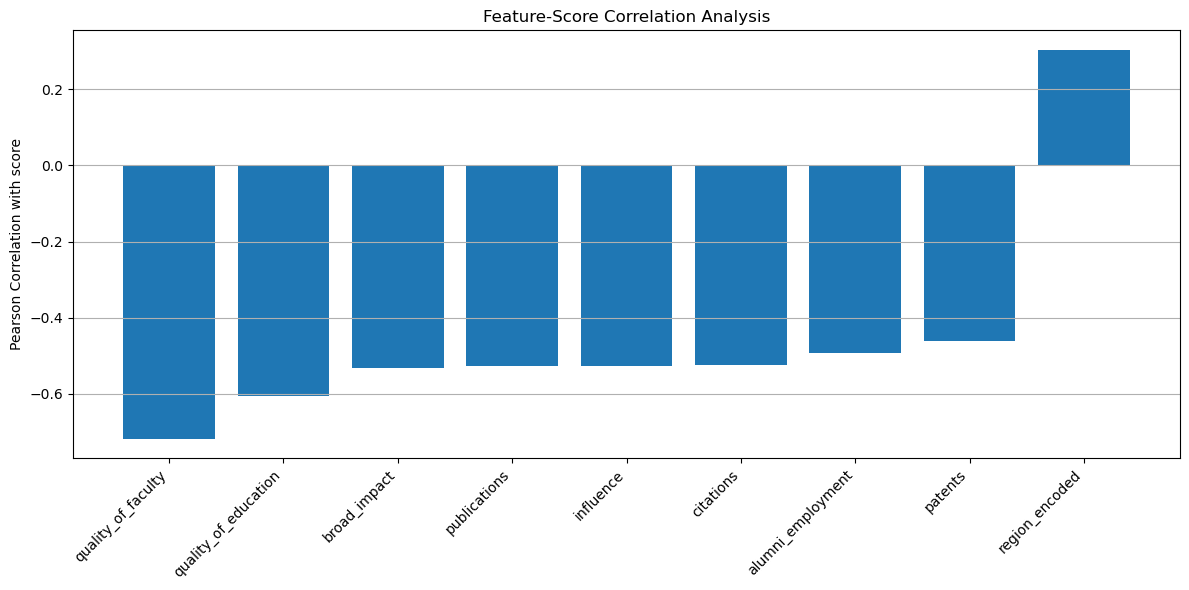

In [445]:
# 计算皮尔逊相关系数
correlations = X.apply(lambda col: col.corr(Y))

# 排序（可选）
correlations = correlations.sort_values(ascending=True)
print(correlations)
# 可视化
plt.figure(figsize=(12, 6))
plt.bar(correlations.index, correlations.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pearson Correlation with score')
plt.title('Feature-Score Correlation Analysis')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 添加内容：特征工程 （助教老师提到的 feature normalize)
### 为什么要对特征进行归一化?
GPT:
1. 提高模型的数值稳定性： 个人理解就是如果特征取值差异尺度过大，会导致$(x^Tx)^{-1}$ 接近奇异矩阵，引入数值计算问题
2. 避免某些特征主导模型权重： 说人话就是，如果不归一化，模型可能会认为数值大的特征更重要，而不是我们期望的这个特征信息本身更重要
3. 提升梯度下降等优化算法的效率：个人理解是比如说在基于信赖域的优化算法中规定了步长，如果这个特征尺度差异很大，要很多轮优化才能趋近于极值
4. 为正则化(L1/L2)做准备：（ps:这是啥? GPT:在 Ridge（L2正则）和 Lasso（L1正则）回归中，我们在最小化损失函数（比如均方误差）时，会额外加上一个惩罚项，这个惩罚项是对模型参数 $\beta$ 的惩罚。  个人理解就是，回归问题中，我们期望模型得到的 回归系数 $\beta$ 的取值范围也得到约束 ， 方法是损失函数上增加 关于回归系数的误差项）若特征未归一化，模型倾向于对大数值的特征赋予小权重，对小数值特征赋予大权重，从而导致不公平的惩罚



### 都有哪些归一化方法?
GPT:
1. Min-Max归一化：将特征取值缩放到[0,1]；保留原始分布
2. Z-score标准化： $x’ = \frac{x - \mu}{\sigma}$ 均值为0,方差为1；适合正态分布
3. 最大绝对值归一化： $x‘ = \frac{x}{max(|x|)}$ 保持符号所放到[-1,1]
4. L2和L1归一化： $x‘_{L2} = \frac{x}{||x||_2}$适合词向量，图像特征,KNN  , $x‘ _{L1} = \frac{x}{ ||x||_1}$适合稀疏文本，逻辑回归

### 针对本次数据的 feature normalization
    使用 Min-Max归一化


In [446]:
# 1. 将特征的取值归一化
# Input: 筛选出来的特征 X type是DataFrame
# Ouput: 归一化之后的特征 X_normalized
#scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
#scaler = StandardScaler()
scaler = Normalizer(norm='l2')
X_normalized = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)


## 四、模型构建

In [ ]:
# 2.将数据集划分成  8：2的训练集和测试集
# 输入是归一化后的 的特征 X_normalized 和标签Y
x_train ,x_test ,y_train , y_test = train_test_split(X_normalized , Y , test_size=0.2 , random_state=RANDOM_SEED) 
print(f"total data: X->{X_normalized.shape} , Y->{Y.shape}")
print(f"train data: x_train->{x_train.shape} , y_train->{y_train.shape}")
print(f"test  data: x_test ->{x_test .shape} , y_test ->{y_test.shape}")

total data: X->(2000, 9) , Y->(2000,)
train data: x_train->(1600, 9) , y_train->(1600,)
test  data: x_test ->(400, 9) , y_test ->(400,)


### 添加内容： 尝试多种回归模型
#### 都有哪些基础回归模型？ 他们是适用场景是怎么样的？
1. 线性回归（LinearRegression）
2. 岭回归（Ridge），对多重共线性鲁棒（说人话就是：一个特征可以被其他一个或多个特征（近似）线性表示），引入L2正则项将损失函数变为 
$$ Loss_{Ridge} = \sum_{i=1}^{n} (y_i - X_i^T \beta)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$   
3. Lasso回归： 将损失函数扩充为
$$ Loss_{lasso} = \sum_{i=1}^{n} (y_i - X_i^T \beta)^2 + \alpha \sum_{j=1}^{p} |\beta_j|$$ 
4. Elastic Net ：结合了 Ridge 和 Lasso的惩罚项 变成:
$$ Loss_{Elastic} = \sum_{i=1}^{n} (y_i - X_i^T \beta)^2 + \alpha( (1-\lambda) \sum_{j=1}^{p} \beta_j^2 +  \lambda\sum_{j=1}^{p} |\beta_j| ) $$ 
  Elastic Net 适合 特征多、特征间相关性强、希望稀疏 + 稳定并存 的回归问题。 当$\alpha=0$时就是线性回归，当$\lambda = 0$时类似Ridge回归 

>Ridge 回归（岭回归）和 Lasso 回归 都是 线性回归的正则化版本，目的是在存在多重共线性（特征之间高度相关）或高维特征（特征数量接近或大于样本数量）时，提高模型的泛化能力，防止过拟合。 Lasso回归有特征选择的能力（会将某些回归系数变成0,当特征维度较高的时候，用来降低维度，Ridge会将回归系数边的小，但不为0）



In [448]:
# 3. 创建回归模型
class LinearModelBase:
    def __init__(self, model, alpha=None , l1_ratio=None):
        self._model = model
        self._alpha = alpha
        self._l1_ratio = l1_ratio
        self._feature_names = None
        self._rmse = None
        self._R2 = None

        model_name = type(self._model).__name__
        alpha_info = f"(alpha = {self._alpha})" if self._alpha is not None else ""
        l1_ratio = f"(l1_ratio = {self._l1_ratio})" if self._l1_ratio is not None else ""
        self._name = f"{model_name} {alpha_info} {l1_ratio}".strip()

    def fit(self, x_train, y_train, feature_names=None):
        self._model.fit(x_train, y_train)
        self._feature_names = feature_names

    def predict(self, x_test):
        return self._model.predict(x_test)

    def report(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        self._rmse = rmse
        self._R2 = r2_score(y_test , y_pred)
        print(f"{self._name} with rmse={self._rmse} R2={self._R2}")
        return rmse

    def log_model_info(self):
        print(f"Intercept (beta0) = {self._model.intercept_}")
        for name, coef in zip(self._feature_names, self._model.coef_):
            print(f"Feature: {name} Coef: {coef:.6f}")

class LinearModel(LinearModelBase):
    def __init__(self):
        super().__init__(LinearRegression())

class RidgeModel(LinearModelBase):
    def __init__(self, alpha=1.0):
        super().__init__(Ridge(alpha=alpha), alpha=alpha)

class LassoModel(LinearModelBase):
    def __init__(self, alpha=1.0):
        super().__init__(Lasso(alpha=alpha), alpha=alpha)

class ElasticModel(LinearModelBase):
    def __init__(self, alpha=1, l1_ratio=0.5):
        super().__init__(ElasticNet(alpha=alpha , l1_ratio=l1_ratio), alpha, l1_ratio)

total_feature_name = X_normalized.keys()
models = [LinearModel() , RidgeModel(1) , LassoModel(1) , ElasticModel(1 , 0.5)]
best_model = None
min_rmse = 10000
for m in models:
    m.fit(x_train , y_train , total_feature_name)
    y_pred = m.predict(x_test)
    each_rmse = m.report(y_test , y_pred)
    if each_rmse < min_rmse:
        best_model= m
        min_rmse = each_rmse

best_model.log_model_info()

    

LinearRegression with rmse=1.6415503237083309 R2=0.9298901248856687
Ridge (alpha = 1) with rmse=1.5722174201897432 R2=0.9356874100929706
Lasso (alpha = 1) with rmse=6.2062762952646615 R2=-0.002150628375171104
ElasticNet (alpha = 1) (l1_ratio = 0.5) with rmse=6.192368810045396 R2=0.0023357265384332804
Intercept (beta0) = 71.56440873427829
Feature: quality_of_faculty Coef: -7.743947
Feature: publications Coef: -10.449719
Feature: citations Coef: -8.015057
Feature: alumni_employment Coef: -11.383339
Feature: influence Coef: -12.747991
Feature: quality_of_education Coef: -10.138224
Feature: broad_impact Coef: -11.997386
Feature: patents Coef: -10.064286
Feature: region_encoded Coef: 41.410089


## 分析与思考
嘻嘻嘻，Pipline= Target Encoding 将region特征数值化 -> 基于L2的特征归一化 -> Ridge（alhpa=1)回归模型时
* rmse=1.5722174201897432 
* $R^2$ =0.9356874100929706
### 在因变量自变量相关性分析
分析：可视化后发现 特征 quality_of_faculty 与score的相关性(负相关)最高。相关性高说明socre受到 quality_of_faculty的影响大一些。

思考：那么 quality_of_faculty这个特征纳入模型中，能够提升模型的预测能力。因为 **相关性不代表因果性（因为混杂变量、巧合、顺序和机制）** 所以截至到目前的分析，我们不能认为 教师素质高导致了学校评分高。（这里来自GPT：如果要分析因果关系还需要通过 A/B实验、Granger实验等方法分析）
### 类别特征转换成数值特征（详见上文）
分析：常见的处理方法包括One-Hot Encoding ,Lable Encoding ，Target Encoding. 这样可以使模型使用上 类别特征。

思考：在操作上是非常有必要的，因为通过相关性分析，region特征和score之间还存在0.3左右的相关性，如果不用，那么会导致决定系数 $R^2$ 降低，也就是有region后模型的能解释更多的score变化。
### 特征归一化（详见上文）
特征归一化方法有：Min-Max归一化 ，最大绝对值归一化，基于正台分布的归一化和基于L2/L1归一化。

归一化操作的收益在： 避免单个特征取值尺度上的差距很大导致的病态矩阵问题， 避免多个特征取值之间取值差异很大导致模型学到了错误的东西， 避免 类似信赖域 的优化算法迭代次数太多，便于后续使用 基于 L2/L1的 回归模型（减轻特征共线性带来的影响）

### 多种回归模型
使用了： Linear Regression ， Ridge ， Lasso ， ElasticModel模型 

思考：通过各个模型对损失函数的定义，Ridge可以缓解 特征共线性问题，Lasso可以降低模型维度（因为某些回归系数会是0） ， Elastic能否综合上述两者的优势